In [1]:
# coding=utf-8
from __future__ import print_function, absolute_import
from gm.api import *

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

## calc
from scipy.stats import linregress

In [2]:
factor_df = pd.read_parquet(r'data\factors\emotion\psy_12.parquet')
factor_df['grouped'] = factor_df.groupby('date')[factor_df.columns[0]].transform(
    lambda s: pd.cut(s, 10, labels=False)
)

In [ ]:
factor_df.groupby('grouped').mean()

,emotion_psy_12
grouped,
0,1.59986039
1,16.53809551
2,24.82006633
3,33.16978383
4,43.98960105
5,52.84103522
6,60.97449284
7,69.01487365
8,77.01044639


In [11]:
factor_disturbion = factor_df.grouped.value_counts().sort_index()
factor_disturbion.index += 1
factor_disturbion

grouped
1      33904
2      34676
3     117497
4     257873
5     557524
6     453482
7     335017
8     171489
9      56766
10     12842
Name: count, dtype: int64

In [3]:
def load_data():
    data_path = r'.\data\raw\all.parquet'
    data = pd.read_parquet(data_path)
    return data

def load_factor_df(factor_typeI, factor_name):
    factor_path = rf'.\data\factors\{factor_typeI}\{factor_name}.parquet'
    factor_df = pd.read_parquet(factor_path)
    return factor_df

In [4]:
data = load_data()
factor_df = load_factor_df('momentum', 'slope_14')

cut = pd.qcut if 10 else pd.cut
factor_df['grouped'] = factor_df.groupby('date')[factor_df.columns[0]].transform(
    lambda s: cut(s, 10, labels=False, duplicates='drop')
)

In [5]:
def calc_forward_ret_data(data, ret_nd=None, ):
    """计算未来收益率
    """
    ## params init
    ret_nd = ret_nd if ret_nd else [1,5,10]

    return_data_lst = []
    for nd in ret_nd:
        forward_return_data = (
            data.close
            .unstack()
            .pct_change(nd, fill_method=None)
            .shift(-nd)     # 计算已知的未来收益
            .stack()
        )
        return_data_lst.append(forward_return_data)
    forward_return_data = pd.concat(return_data_lst, axis=1).sort_index()
    forward_return_data.columns = [f'forward_ret_{nd}d' for nd in ret_nd]
    return forward_return_data

In [6]:
forward_return_data = calc_forward_ret_data(data)

In [12]:
forward_return_data

forward_ret_1d  forward_ret_5d  forward_ret_10d
date       symbol                                                      
2024-01-02 SHSE.600000      0.00606054      0.00151513      -0.00151513
           SHSE.600004     -0.00925920     -0.04938273       0.01748979
           SHSE.600006     -0.00343040     -0.04459687      -0.03945110
           SHSE.600007     -0.01157875     -0.01157875      -0.04842096
           SHSE.600008      0.00367631     -0.00367671      -0.00367671
...                                ...             ...              ...
2025-09-01 SZSE.301658     -0.01964233             NaN              NaN
           SZSE.301662      0.08127268             NaN              NaN
           SZSE.301665      0.02656850             NaN              NaN
           SZSE.301678     -0.06761957             NaN              NaN
           SZSE.302132      0.00596647             NaN              NaN

[2052092 rows x 3 columns]

In [13]:
forward_return_grouped_data = pd.concat([forward_return_data, factor_df['grouped']], axis=1).dropna(how='all')
forward_return_grouped_data = forward_return_grouped_data.groupby(['grouped', forward_return_grouped_data.index.get_level_values(0)]).mean()

In [18]:
series = forward_return_grouped_data['forward_ret_1d']
series

grouped  date      
0.0      2024-02-07    0.06112080
         2024-02-08    0.04832812
         2024-02-19    0.01688432
         2024-02-20    0.02088327
         2024-02-21    0.01964679
                          ...    
9.0      2025-08-27    0.00757378
         2025-08-28   -0.00166591
         2025-08-29    0.00989632
         2025-09-01   -0.01569063
         2025-09-02           NaN
Name: forward_ret_1d, Length: 3790, dtype: float64

In [ ]:
series.unstack().T

grouped,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
date,,,,,,,,,,
2024-02-07,0.06112080,0.07772646,0.08759153,0.09519314,0.09480939,0.08767922,0.08122836,0.06486592,0.03921964,0.00586141
2024-02-08,0.04832812,0.05564581,0.05590040,0.05234376,0.04403647,0.03506491,0.02639797,0.01277220,-0.00130125,-0.00055879
2024-02-19,0.01688432,0.02144451,0.02171980,0.02150836,0.01486628,0.01132310,0.00932851,0.00398782,0.00208769,0.00103793
2024-02-20,0.02088327,0.02770446,0.02810384,0.02280287,0.01866247,0.01500503,0.01201199,0.01065164,0.00721993,0.00236036
2024-02-21,0.01964679,0.02428443,0.03030119,0.03150145,0.02935403,0.02510030,0.02450295,0.02096630,0.01545233,0.00859833
...,...,...,...,...,...,...,...,...,...,...
2025-08-27,0.00078668,0.00605538,0.00632047,0.00558997,0.00623600,0.00871311,0.00865469,0.00894616,0.00620687,0.00757378
2025-08-28,-0.00241153,-0.00038783,-0.00322748,-0.00244578,-0.00401946,-0.00288757,-0.00279728,-0.00273669,-0.00040761,-0.00166591
2025-08-29,0.00860497,0.00846137,0.00753000,0.00982862,0.00829782,0.01227996,0.01186180,0.00773737,0.01069053,0.00989632


<Axes: xlabel='date'>

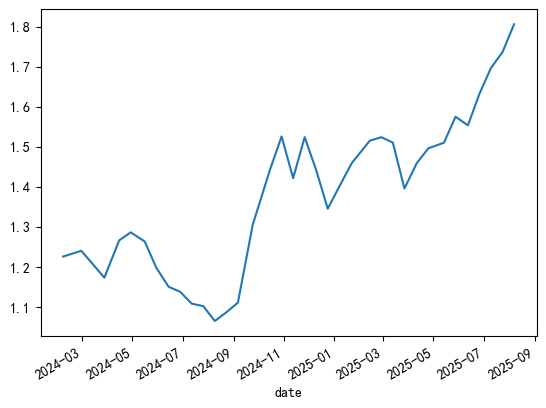

In [129]:
grouped = pd.concat([forward_return_data['forward_ret_10d'], factor_df['grouped']], axis=1).dropna(how='all').groupby('grouped')
(grouped.get_group(0).groupby(level=0).mean().iloc[::10, 0] + 1).cumprod().plot()